# Visulization Code

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial import Delaunay
from scipy.interpolate import griddata
from matplotlib.tri import Triangulation
from xml.etree import ElementTree as ET
import glob
import base64

## Read and Extract Data from vtu Files from utils.py

In [2]:
import sys
sys.path.append('.')  # Make sure current directory is in path
from stefan_utils import read_stefan_vtu_snapshot

## φ Visualization

In [32]:
def plot_temperature_field(snapshot_dir, case_type='ice_melting', output_dir=None, snapshot_name='snapshot'):
    """Plot temperature fields (or monomer concentrations) based on case type."""
    # Load data
    points, Tl, Ts, phi, vx, vy = read_stefan_vtu_snapshot(snapshot_dir)
    tri = Delaunay(points[:, :2])

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))

    # Left subplot
    ax1 = axes[0]
    tpc1 = ax1.tripcolor(points[:, 0], points[:, 1], tri.simplices, Tl,
                         shading='gouraud', cmap='jet')

    if case_type.lower() == 'protein_aggregation':
        label1 = 'Monomer in Aggregate'
        title1 = 'Monomer Concentration (Inside Aggregate)'
    else:
        label1 = '$T_l$'
        title1 = 'Liquid Temperature ($T_l$)'

    fig.colorbar(tpc1, ax=ax1, label=label1)
    ax1.set_title(title1, fontsize=14)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_aspect('equal')

    # Right subplot
    ax2 = axes[1]
    tpc2 = ax2.tripcolor(points[:, 0], points[:, 1], tri.simplices, Ts,
                         shading='gouraud', cmap='jet')

    if case_type.lower() == 'protein_aggregation':
        label2 = 'Monomer Outside Aggregate'
        title2 = 'Monomer Concentration (Outside Aggregate)'
    else:
        label2 = '$T_s$'
        title2 = 'Solid Temperature ($T_s$)'

    fig.colorbar(tpc2, ax=ax2, label=label2)
    ax2.set_title(title2, fontsize=14)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_aspect('equal')

    fig.suptitle('Field Visualization', fontsize=16)

    # Save if needed
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        fig.savefig(os.path.join(output_dir, f"{snapshot_name}_temperature_fields.png"), dpi=300)

    plt.show()

def plot_phi_field(snapshot_dir, output_dir=None, snapshot_name='snapshot'):
    from stefan_utils import read_stefan_vtu_snapshot

    points, _, _, phi, _, _ = read_stefan_vtu_snapshot(snapshot_dir)
    tri = Delaunay(points[:, :2])

    fig = plt.figure(figsize=(16, 7))

    # === 1. 3D Phase Field ===
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    surf = ax1.plot_trisurf(points[:, 0], points[:, 1], phi, triangles=tri.simplices,
                            cmap='jet', linewidth=0.1, edgecolor='none', antialiased=True)
    fig.colorbar(surf, ax=ax1, shrink=0.5, aspect=10, label='Phi')
    ax1.set_title('Phase Field ($\\phi$)', fontsize=16)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('$\\phi$')
    ax1.view_init(elev=30, azim=-45)

    # === 2. 2D Top View ===
    ax2 = fig.add_subplot(1, 2, 2)
    tpc = ax2.tripcolor(points[:, 0], points[:, 1], tri.simplices, phi, shading='gouraud', cmap='jet')
    fig.colorbar(tpc, ax=ax2, label='Phi')
    ax2.set_title('Phase Field ($\\phi$) - Top View', fontsize=16)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_aspect('equal')

    fig.suptitle('Phase Field Visualizations', fontsize=18)

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        fig.savefig(os.path.join(output_dir, f"{snapshot_name}_phi_field_combined.png"), dpi=300)

    plt.tight_layout()
    plt.show()


def plot_velocity_field(snapshot_dir, case_type="ice_melting", output_dir=None, snapshot_name='snapshot'):
    from stefan_utils import read_stefan_vtu_snapshot

    points, _, _, phi, vx, vy = read_stefan_vtu_snapshot(snapshot_dir)

    tri = Delaunay(points[:, :2])
    v_mag = np.sqrt(vx**2 + vy**2)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 14))

    # === 1. Velocity vectors over phi (2D view) ===
    tpc = ax1.tripcolor(points[:, 0], points[:, 1], tri.simplices, phi,
                        shading='gouraud', cmap='jet')
    fig.colorbar(tpc, ax=ax1, label='Phi')
    ax1.quiver(points[:, 0], points[:, 1], vx, vy, angles='xy',
               scale_units='xy', scale=1.5, color='black')
    ax1.set_title('Velocity Field over $\phi$', fontsize=14)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_aspect('equal')

    # === 2. Velocity magnitude contour (2D view) ===
    x_min, x_max = points[:, 0].min(), points[:, 0].max()
    y_min, y_max = points[:, 1].min(), points[:, 1].max()
    xi, yi = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    vmi = griddata(points[:, :2], v_mag, (xi, yi), method='linear')

    contour = ax2.contourf(xi, yi, vmi, levels=30, cmap='jet')
    fig.colorbar(contour, ax=ax2, label='|v|')
    ax2.set_title('Velocity Magnitude (2D Contour)', fontsize=14)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_aspect('equal')

    fig.suptitle('Velocity Field Visualizations', fontsize=18)

    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        fig.savefig(os.path.join(output_dir, f"{snapshot_name}_velocity_field_combined.png"), dpi=300)

    plt.tight_layout()
    plt.show()


# Results

## Protein Aggregation

In [42]:
import re
from IPython.display import Markdown, display

# Load the file
with open("protein_aggregation_report.md", "r") as file:
    content = file.read()

# Replace ( \latex ) → $\latex$ for inline
content_fixed = re.sub(r"\(\s*(\\[^\(\)]+?)\s*\)", r"$\1$", content)

# Replace block-level LaTeX with $$...$$ if needed (optional)
# content_fixed = re.sub(r"\$\$([^\$]+)\$\$", r"\n$$\1$$\n", content_fixed)

# Display updated markdown
display(Markdown(content_fixed))


This section documents the modeling, implementation, and analysis of protein aggregation using a Stefan-type moving boundary solver, based on insights developed during discussions with Claude AI.

---

## Overview

Protein aggregation was modeled as a **diffusion-limited growth** problem with **patch-dependent interfacial kinetics**, adapting a solver originally designed for ice melting (e.g., Frank sphere) to simulate irreversible binding of monomers onto protein aggregates.  

The solver used a **single level-set approach** with **spatially varying boundary coefficients** to mimic patch behavior.

---

## Mathematical Model

### 1. **Protein Transport Equation (in Solution Region, $\phi < 0$)**

$$
\frac{\partial \rho}{\partial t} = \nabla \cdot (D(x) \nabla \rho)
$$

- $\rho(x,t)$: protein concentration  
- $D(x)$: position-dependent diffusivity

### 2. **Laplace Equation (Inside Aggregate, $\phi > 0$)**

$$
\nabla^2 \rho = 0
$$

Assumes zero diffusion within the aggregate.

### 3. **Level Set Evolution Equation**

$$
\frac{\partial \phi}{\partial t} + v_n |\nabla \phi| = 0
$$

- $\phi(x,t)$: level set function (negative in solution, positive in aggregate)  
- $v_n$: interface normal velocity

### 4. **Jump Condition at Interface ($\phi = 0$)**

$$
v_n = \frac{k_s \nabla \rho_s \cdot \mathbf{n} - k_l \nabla \rho_l \cdot \mathbf{n}}{L \rho_l}
$$

- $k_s, k_l$: binding rates (patch-specific)  
- $L$: binding energy  
- $\rho_l$: solution density

### 5. **Robin Boundary Condition at Interface**

$$
\nabla \rho \cdot \mathbf{n} + \alpha \rho = \alpha \rho_{eq}
$$

- $\alpha$: binding coefficient (varies by patch)  
- $\rho_{eq}$: equilibrium concentration

---

## Implementation Details

### Key Variables

| Variable | Description |
|----------|-------------|
| `phi` | Level set function |
| `T_l` | Protein concentration in solution |
| `T_s` | Protein concentration in aggregate (fixed at 0) |
| `v_interface` | Interface velocity |

### Physical Parameters

```cpp
alpha_s = 0.0;     // No diffusion inside aggregates
alpha_l = 0.1;     // Diffusion in solution
k_s = 1.5;         // Binding rate for hydrophobic patches
k_l = 0.5;         // Binding rate for hydrophilic patches
L = 1.0;           // Binding energy
rho_l = 1.0;       // Solution density
Tinterface = 0.0;  // Equilibrium concentration at interface
Twall = 1.0;       // Concentration at boundaries
```

### Patch Implementation (C++ Snippet)

```cpp
bool is_hydrophobic_patch(DIM(double x, double y, double z)) {
  double r = sqrt(SQR(x) + SQR(y) CODE3D(+ SQR(z)));
  return (r < 0.21 || (r < 0.3 && x > 0.1));
}

bool is_hydrophilic_patch(DIM(double x, double y, double z)) {
  double r = sqrt(SQR(x) + SQR(y) CODE3D(+ SQR(z)));
  return (r < 0.3 && !is_hydrophobic_patch(DIM(x, y, z)));
}
```
### Velocity Modification Based on Patch Type
```cpp
bool hydrophobic = is_hydrophobic_patch(DIM(xyz[0], xyz[1], xyz[2]));
double growth_factor = hydrophobic ? 2.0 : 0.5;

foreach_dimension(d) {
  jump.ptr[d][n] *= growth_factor;
}
```

## Solver Workflow

**Initialize:**
- Create initial spherical protein aggregate  
- Set up concentration gradient from boundaries  

**For each timestep:**
- Extend fields across interface  
- Compute interfacial velocity based on concentration gradients  
- Advance level set function  
- Update grid based on new level set  
- Solve diffusion equation in both domains  
- Check for convergence  

**Visualization:**
- Monitor phase field ($\phi$)  
- Track concentration fields ($T_l$, $T_s$)  
- Visualize interface velocity  

---

## Results & Analysis

### Observations
- Initial growth phase with non-zero velocity  
- Eventual steady state with zero interface velocity  
- Uniform, circular growth pattern  
- Stable concentration gradient  

### Expected vs. Actual Behavior
The model successfully captured:
- ✓ Diffusion-driven growth  
- ✓ Zero diffusion inside aggregates  
- ✓ Concentration gradient from boundaries  
- ✓ Evolution to physically realistic steady state  

However, the patches did not produce visible anisotropy as expected:
- The growth remained uniformly circular  
- Patch effects were not strong enough to break symmetry  

### Interpretation
The simulation results align with diffusion-limited growth theory, showing:
- Initial rapid growth when concentration gradient is steep  
- Gradual slowing as nearby monomers are depleted  
- Eventual steady state when diffusion rate balances attachment/detachment rates  

The **uniform circular shape** suggests that patch effects need enhancement to create more realistic, **non-uniform** protein aggregates.


In [13]:
# Set path to the snapshot directory (where the 5 .vtu files are)
snapshot_dir = '/home/faranak/CASL/workspace/simulations_output/stefan_mls/lmin_5_lmax_7_snapshot100.vtu'

# Choose the case: 'ice_melting', 'frank_sphere', or 'protein_aggregation'
case_type = 'protein_aggregation'

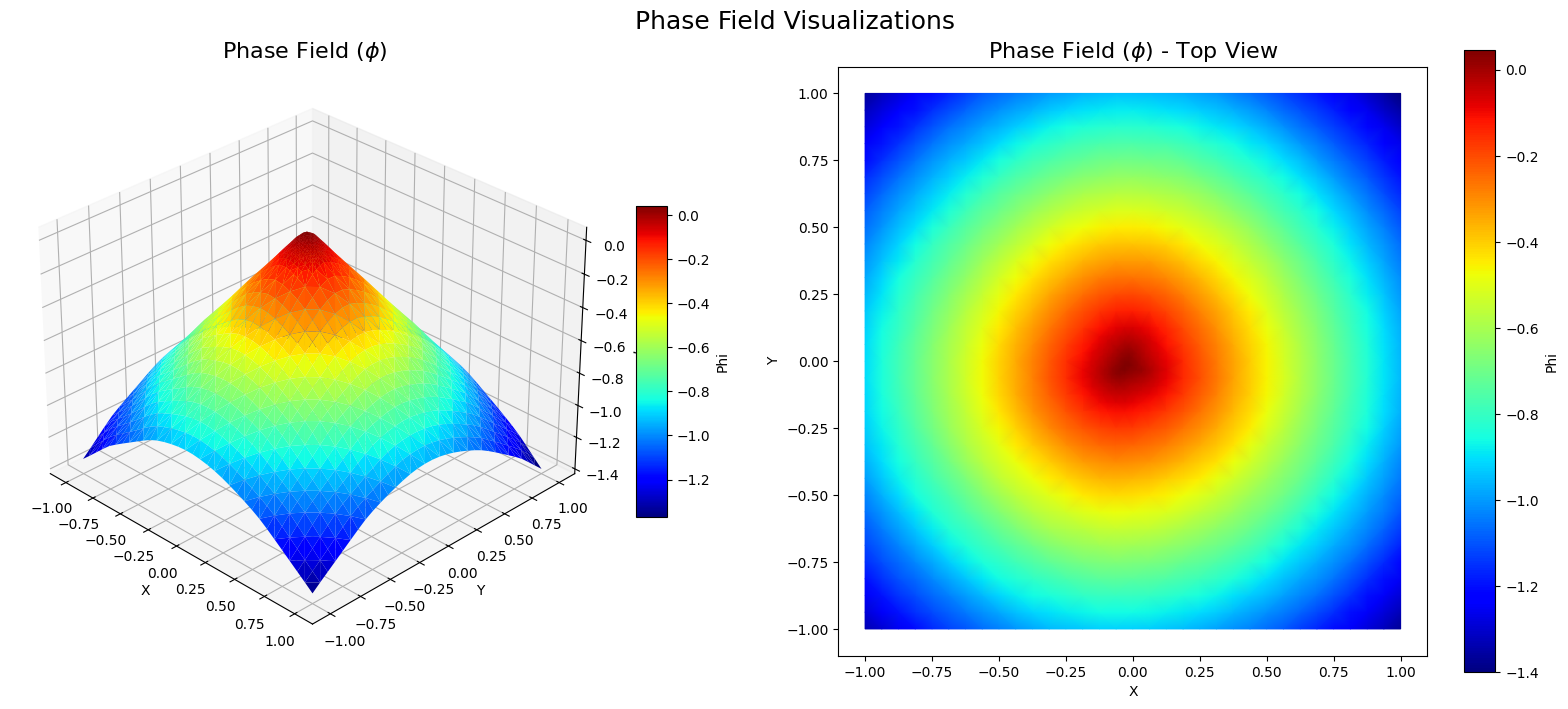

In [28]:
# Run all visualizations
plot_phi_field(snapshot_dir)

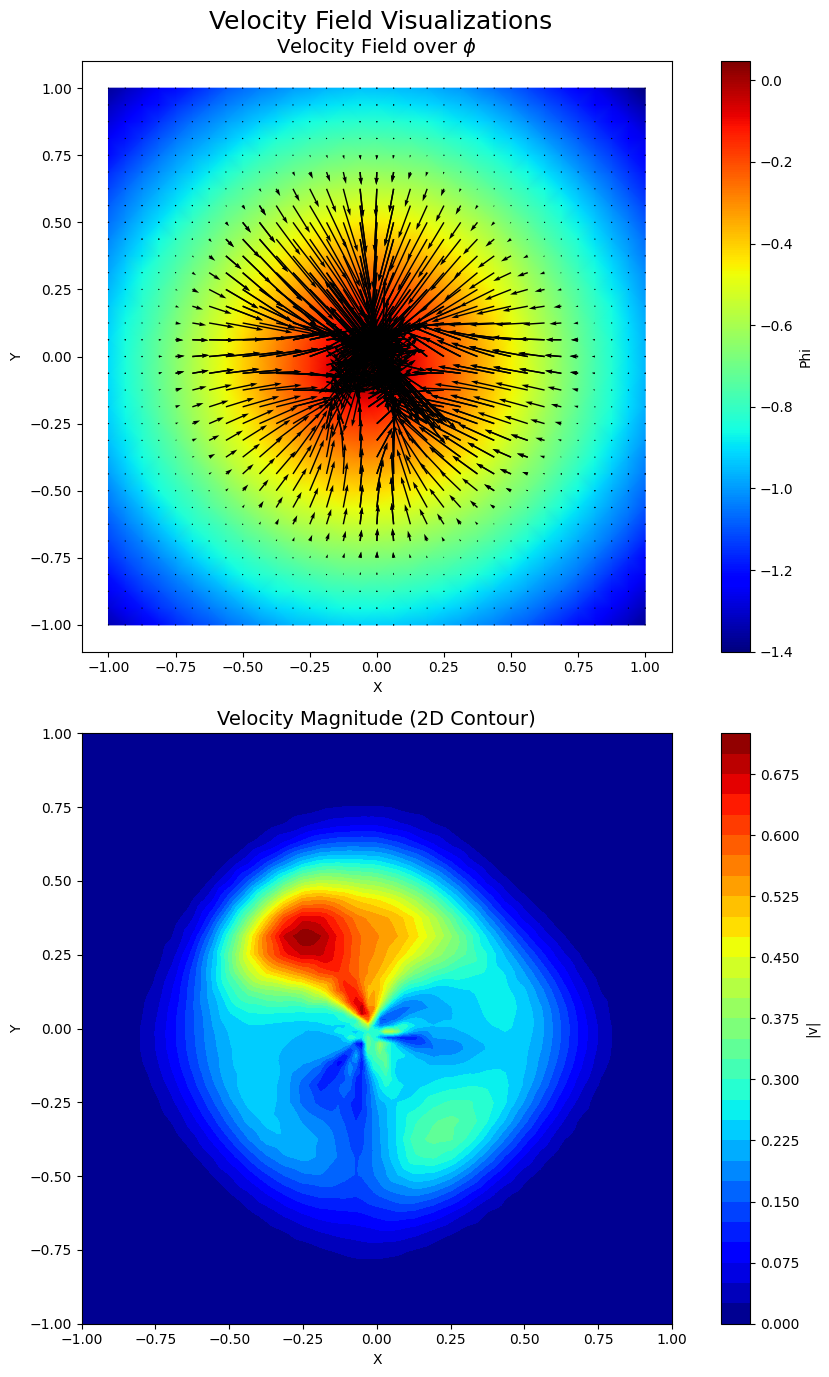

In [33]:
plot_velocity_field(snapshot_dir)

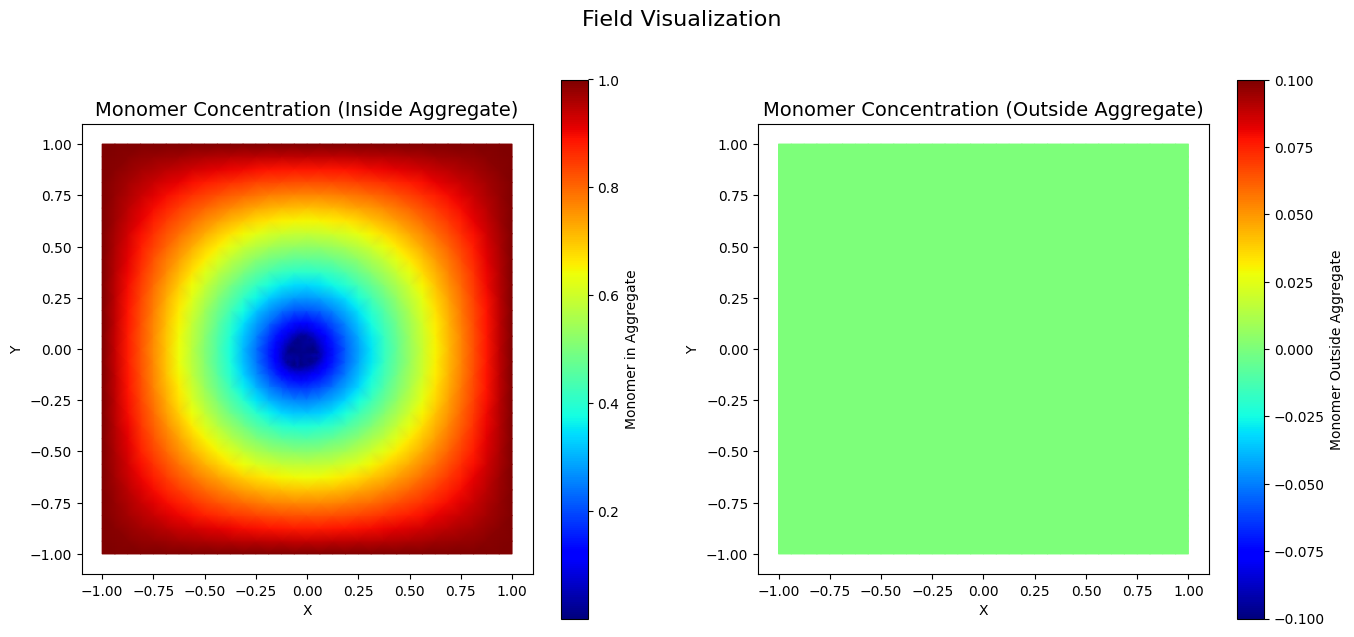

In [11]:
plot_temperature_field(snapshot_dir, case_type=case_type)